In [3]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import mapclassify
import copy
import os
from scipy.spatial import cKDTree
from shapely.geometry import Point,LineString
import us


plt.rcParams['figure.figsize'] = [15, 15]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

table_path = "E:/Projects/PUMS/Tables/"
GIS_path = "E:/Projects/PUMS/GIS_data/"
intermediate_path = table_path + "intermediate_output/"

In [4]:
f_ls = glob.glob(table_path+'raw_data/5_years/2015-2019/psam_pus*')

In [5]:
f_ls[0]

'E:/Projects/PUMS/Tables/raw_data/5_years/2015-2019\\psam_pusa.csv'

In [6]:
df_ls=[]
for f in f_ls:
    print(f)
    df_ls.append(pd.read_csv(f))
    
df = pd.concat(df_ls)

E:/Projects/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusa.csv


C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


E:/Projects/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusb.csv
E:/Projects/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusc.csv
E:/Projects/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusd.csv


In [7]:
trans = pd.read_csv(table_path+"puma_migpuma1_pwpuma00.csv")

In [8]:
trans = trans.rename(columns={"Place of Work State (PWSTATE2) or Migration State (MIGPLAC1)": "MIGSP"})
trans = trans.rename(columns={"PWPUMA00 or MIGPUMA1": "MIGPUMA"})
trans = trans.rename(columns={"State of Residence (ST)": "ST"})

In [9]:
trans['PUMA'] = trans['PUMA'].astype('int64').astype('str').str.rjust(5, "0")
trans['ST'] = trans['ST'].astype('int16').astype('str').str.rjust(2, "0")
trans['MIGSP'] = trans['MIGSP'].astype('int64').astype('str').str.rjust(2, "0")
trans['MIGPUMA'] = trans['MIGPUMA'].astype('int64').astype('str').str.rjust(5, "0")

In [10]:
trans['PUMA2'] = trans['ST'] + trans['PUMA']
trans['MIGPUMA2'] = trans['MIGSP'] + trans['MIGPUMA']

In [11]:
df1 = df.dropna(subset=['MIGPUMA'])

In [12]:
df1.loc[:,'MIGPUMA'] = df1['MIGPUMA'].astype('int64').astype('str').str.rjust(5, "0")
df1.loc[:,'PUMA'] = df1['PUMA'].astype('int64').astype('str').str.rjust(5, "0")
df1.loc[:,'MIGSP'] = df1['MIGSP'].astype('int64').astype('str').str.rjust(2, "0")
df1.loc[:,'ST'] = df1['ST'].astype('int64').astype('str').str.rjust(2, "0")

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [13]:
df1.loc[:,'PUMA_D'] = df1['ST'] + df1['PUMA']
df1.loc[:,'MIGPUMA_O'] = df1['MIGSP'] + df1['MIGPUMA']

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [14]:
df1 = pd.merge(df1,trans,how='left',left_on='PUMA_D',right_on='PUMA2').drop(['ST_y','PUMA_y','MIGSP_y','MIGPUMA_y','PUMA2'],axis=1).rename(columns={"MIGPUMA2": "MIGPUMA_D"})

In [15]:
df1.to_csv(intermediate_path+'df1.csv')

In [16]:
df1[df1['MIGPUMA_O']==df1['MIGPUMA_D']].shape[0]

1186534

In [17]:
print("Ratio of migratoin within same MIGPUMA:" + str(df1[df1['MIGPUMA_O']==df1['MIGPUMA_D']].shape[0]/df1.shape[0]))

Ratio of migratoin within same MIGPUMA:0.5622429938427509


#### Join Population to MIGPUMA

In [18]:
migpuma_cw_orig = pd.read_csv(table_path+ "MIGPUMA2000_MIGPUMA2010_crosswalk.csv")
migpuma_cw_orig = migpuma_cw_orig.dropna(subset=['MigPUMA10'])
migpuma_cw_orig.loc[:,'MIGPUMA'] = migpuma_cw_orig['MigPUMA10'].astype('int64').astype('str').str.rjust(5, "0")
migpuma_cw_orig.loc[:,'MIGSP'] = migpuma_cw_orig['State10'].astype('int64').astype('str').str.rjust(2, "0")
migpuma_cw_orig.loc[:,'MIGPUMA2'] = migpuma_cw_orig.loc[:,'MIGSP'] + migpuma_cw_orig.loc[:,'MIGPUMA']
migpuma_cw = migpuma_cw_orig[['MIGPUMA2','MigPUMA10_Pop10']].drop_duplicates()
migpuma_cw.to_csv(intermediate_path+'migpuma_cw.csv')

In [19]:
migpuma_cw.to_csv(intermediate_path+'migpuma_cw.csv')

In [20]:
puma = gpd.read_file(GIS_path+'ipums_puma_2010.shp')
migpuma = gpd.read_file(GIS_path+"ipums_migpuma_pwpuma_2010.shp")
puma['PUMA2'] = puma['STATEFIP'] + puma['PUMA']
migpuma['MIGPUMA2'] = migpuma['STATEFIP'] + migpuma['MIGPUMA']

### Aggregation of all moves at origin and destination 

In [21]:
orig = df1.groupby('MIGPUMA_O').agg(['sum'])['PWGTP'].reset_index().rename(columns={"sum": "person"})
dest = df1.groupby('PUMA_D').agg(['sum'])['PWGTP'].reset_index().rename(columns={"sum": "person"})
dest_mig = df1.groupby('MIGPUMA_D').agg(['sum'])['PWGTP'].reset_index().rename(columns={"sum": "person"})

orig_dest = df1.groupby(['MIGPUMA_O','MIGPUMA_D']).agg(['sum'])['PWGTP'].reset_index().rename(columns={"sum": "person"})

In [22]:
orig = pd.merge(migpuma,orig,how='left',left_on='MIGPUMA2',right_on='MIGPUMA_O')
dest = pd.merge(puma,dest,how='left',left_on='PUMA2',right_on='PUMA_D')
dest_mig = pd.merge(migpuma,dest_mig,how='left',left_on='MIGPUMA2',right_on='MIGPUMA_D')

#### Join MIGPUMA population and calculate move ratio

In [23]:
orig = pd.merge(orig,migpuma_cw,how='left',left_on='MIGPUMA_O',right_on='MIGPUMA2')
dest_mig = pd.merge(dest_mig,migpuma_cw,how='left',left_on='MIGPUMA_D',right_on='MIGPUMA2')

orig['MigPUMA10_Pop10'] = pd.to_numeric(orig['MigPUMA10_Pop10'].str.replace(',', ''))
dest_mig['MigPUMA10_Pop10'] = pd.to_numeric(dest_mig['MigPUMA10_Pop10'].str.replace(',', ''))

orig['r_person']=orig['person']/orig['MigPUMA10_Pop10']
dest_mig['r_person']=dest_mig['person']/dest_mig['MigPUMA10_Pop10']

### Aggregation of local and out moves at origin and destination 

In [24]:
df1_loc = df1[df1['MIGPUMA_O'] == df1['MIGPUMA_D']] # local moves
df1_out = df1[df1['MIGPUMA_O'] != df1['MIGPUMA_D']] # out moves

dest_loc = df1_loc.groupby('MIGPUMA_D').agg(['sum'])['PWGTP'].reset_index().rename(columns={"sum": "person"})

orig_out = df1_out.groupby('MIGPUMA_O').agg(['sum'])['PWGTP'].reset_index().rename(columns={"sum": "person"})
dest_out = df1_out.groupby('MIGPUMA_D').agg(['sum'])['PWGTP'].reset_index().rename(columns={"sum": "person"})

#### Join MIGPUMA population and calculate move ratio

In [25]:
dest_loc = pd.merge(dest_loc,migpuma_cw,how='left',left_on='MIGPUMA_D',right_on='MIGPUMA2')
orig_out = pd.merge(orig_out,migpuma_cw,how='left',left_on='MIGPUMA_O',right_on='MIGPUMA2')
dest_out = pd.merge(dest_out,migpuma_cw,how='left',left_on='MIGPUMA_D',right_on='MIGPUMA2')

dest_loc['MigPUMA10_Pop10'] = pd.to_numeric(dest_loc['MigPUMA10_Pop10'].str.replace(',', ''))
orig_out['MigPUMA10_Pop10'] = pd.to_numeric(orig_out['MigPUMA10_Pop10'].str.replace(',', ''))
dest_out['MigPUMA10_Pop10'] = pd.to_numeric(dest_out['MigPUMA10_Pop10'].str.replace(',', ''))

dest_loc['r_person']=dest_loc['person']/dest_loc['MigPUMA10_Pop10']
orig_out['r_person']=orig_out['person']/orig_out['MigPUMA10_Pop10']
dest_out['r_person']=dest_out['person']/dest_out['MigPUMA10_Pop10']

In [26]:
dest_loc = pd.merge(migpuma,dest_loc,how='left',left_on='MIGPUMA2',right_on='MIGPUMA_D')

orig_out = pd.merge(migpuma,orig_out,how='left',left_on='MIGPUMA2',right_on='MIGPUMA_O')
dest_out = pd.merge(migpuma,dest_out,how='left',left_on='MIGPUMA2',right_on='MIGPUMA_D')

In [27]:
dest_mig.sort_values(['r_person'],ascending=False).head()

,GISMATCH,STATEFIP,State,MIGPLAC,MIGPUMA,PWSTATE,PWPUMA,geometry,MIGPUMA2_x,MIGPUMA_D,person,MIGPUMA2_y,MigPUMA10_Pop10,r_person
163,4803602,48,Texas,048,03602,48,03602,"POLYGON ((-21525.060 -731702.786, -21476.286 -...",4803602,4803602,64324.0,4803602,194851.0,0.330119
276,1303600,13,Georgia,013,03600,13,03600,"POLYGON ((1139970.774 -320764.357, 1140430.323...",1303600,1303600,37411.0,1303600,116714.0,0.320536
381,1802800,18,Indiana,018,02800,18,02800,"POLYGON ((828729.664 215846.106, 828804.800 21...",1802800,1802800,43803.0,1802800,137974.0,0.317473
376,1801200,18,Indiana,018,01200,18,01200,"POLYGON ((750415.072 339452.147, 750412.018 33...",1801200,1801200,49984.0,1801200,172780.0,0.289293
409,2000700,20,Kansas,020,00700,20,00700,"POLYGON ((80993.405 166521.981, 80986.548 1663...",2000700,2000700,32041.0,2000700,110826.0,0.289111


In [28]:
dest_loc.sort_values(['r_person'],ascending=False).head()

,GISMATCH,STATEFIP,State,MIGPLAC,MIGPUMA,PWSTATE,PWPUMA,geometry,MIGPUMA2_x,MIGPUMA_D,person,MIGPUMA2_y,MigPUMA10_Pop10,r_person
163,4803602,48,Texas,048,03602,48,03602,"POLYGON ((-21525.060 -731702.786, -21476.286 -...",4803602,4803602,33591.0,4803602,194851.0,0.172393
381,1802800,18,Indiana,018,02800,18,02800,"POLYGON ((828729.664 215846.106, 828804.800 21...",1802800,1802800,23287.0,1802800,137974.0,0.168778
926,500590,05,Arkansas,005,00590,05,00590,"POLYGON ((518541.530 -96619.661, 518576.431 -9...",0500590,0500590,47387.0,0500590,287382.0,0.164892
376,1801200,18,Indiana,018,01200,18,01200,"POLYGON ((750415.072 339452.147, 750412.018 33...",1801200,1801200,28157.0,1801200,172780.0,0.162964
585,2101900,21,Kentucky,021,01900,21,01900,"POLYGON ((1013366.142 106193.478, 1013362.984 ...",2101900,2101900,47821.0,2101900,295803.0,0.161665


### Origins of all moves

<AxesSubplot:>

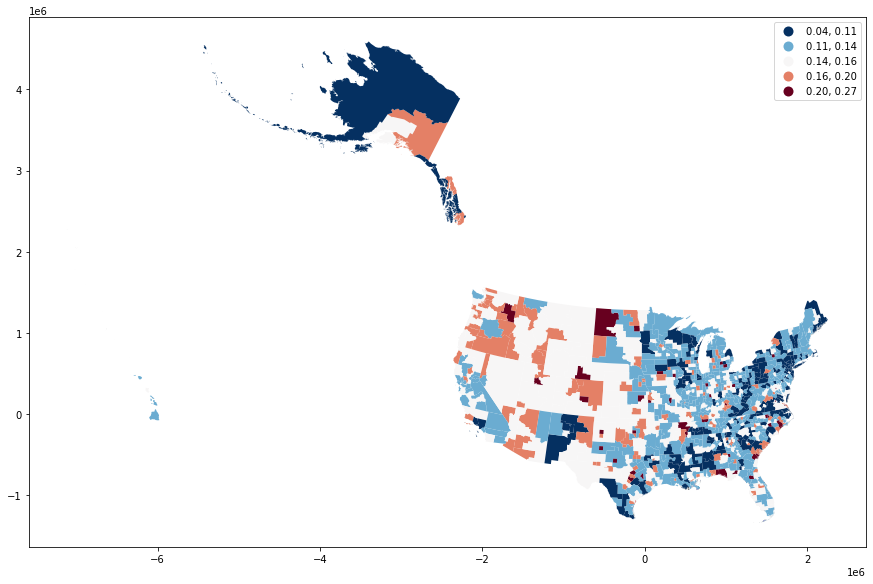

In [29]:
orig.plot(column='r_person',scheme='FisherJenks',
         categorical=False,
         cmap='RdBu_r',
         linewidth=5,
         legend=True)

<AxesSubplot:>

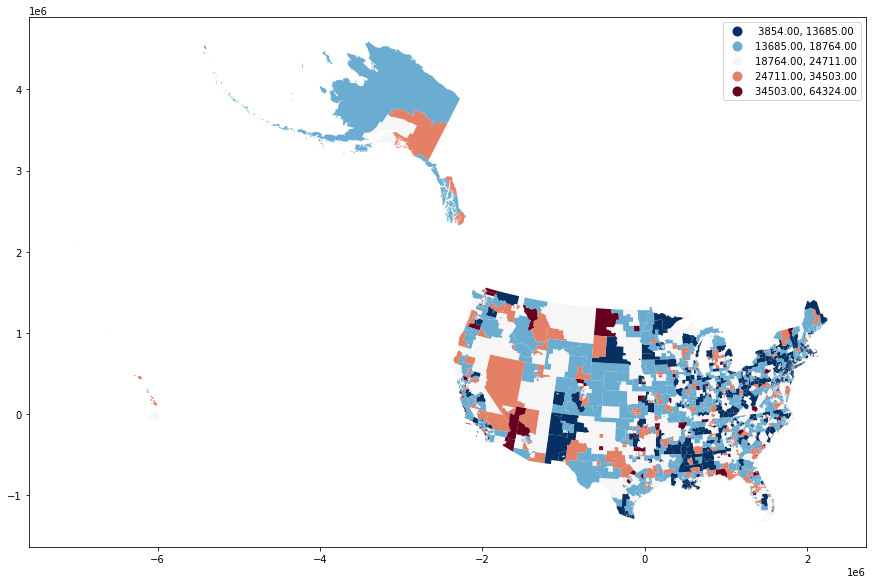

In [30]:
dest.plot(column='person',scheme='FisherJenks',
         categorical=False,
         cmap='RdBu_r',
         linewidth=5,
         legend=True)

<AxesSubplot:>

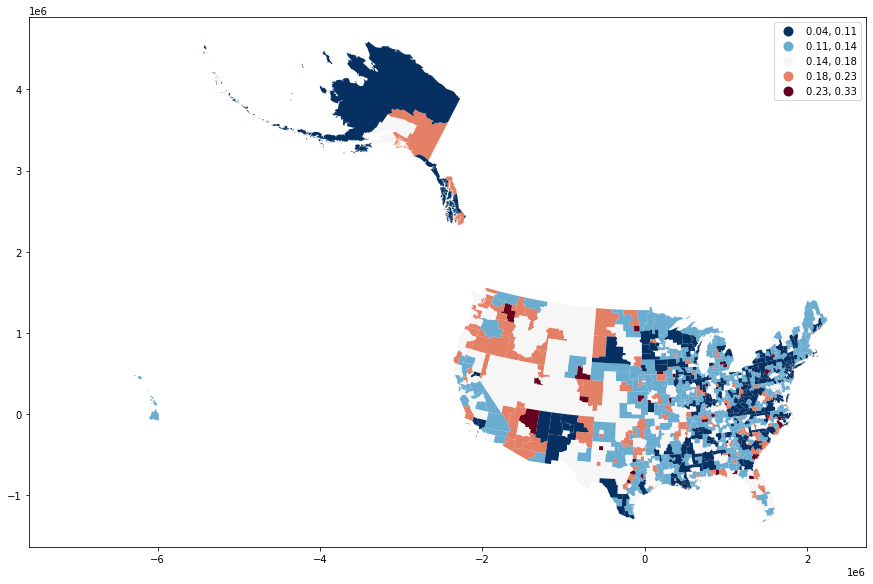

In [31]:
dest_mig.plot(column='r_person',scheme='FisherJenks',
         categorical=False,
         cmap='RdBu_r',
         linewidth=5,
         legend=True)

### Local moves

<AxesSubplot:>

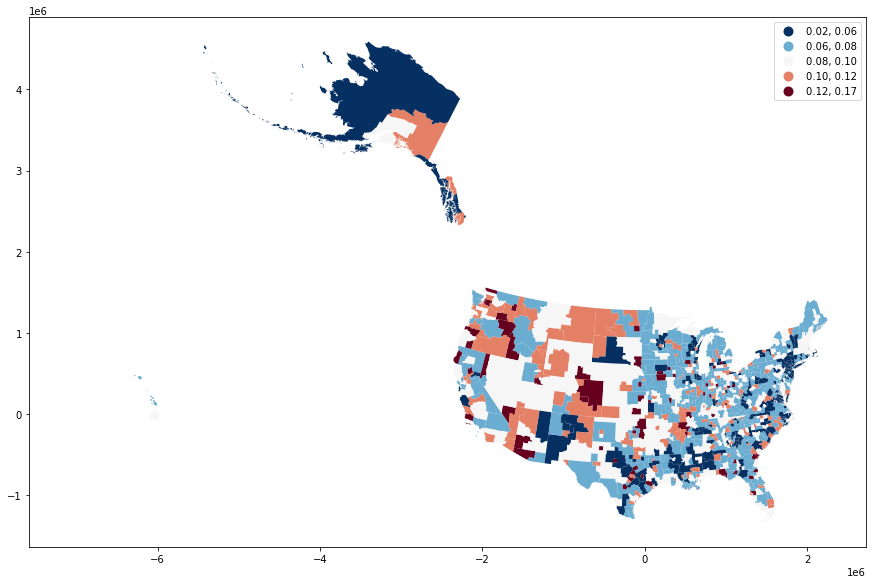

In [32]:
dest_loc.plot(column='r_person',scheme='FisherJenks',
         categorical=False,
         cmap='RdBu_r',
         linewidth=5,
         legend=True)

### Origins of out moves

<AxesSubplot:>

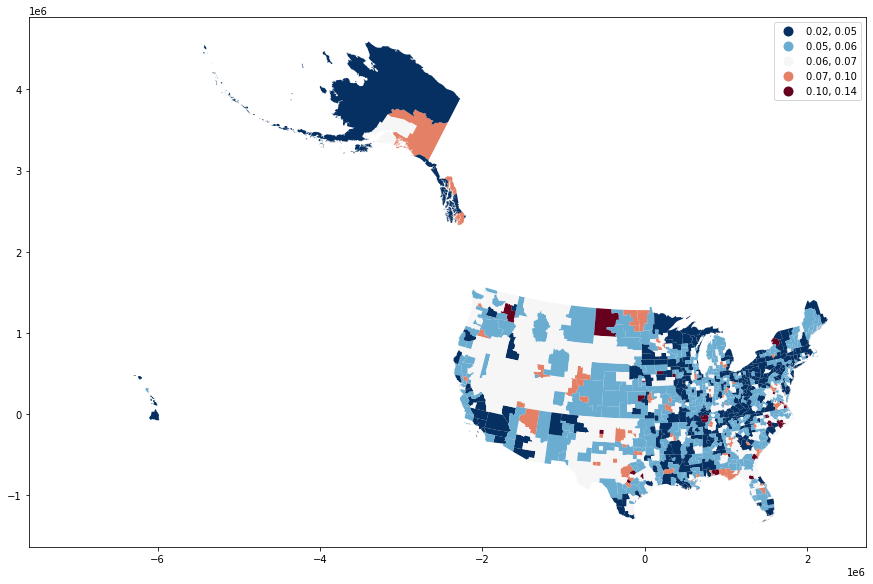

In [33]:
orig_out.plot(column='r_person',scheme='FisherJenks',
         categorical=False,
         cmap='RdBu_r',
         linewidth=5,
         legend=True)

### Destination of out moves

<AxesSubplot:>

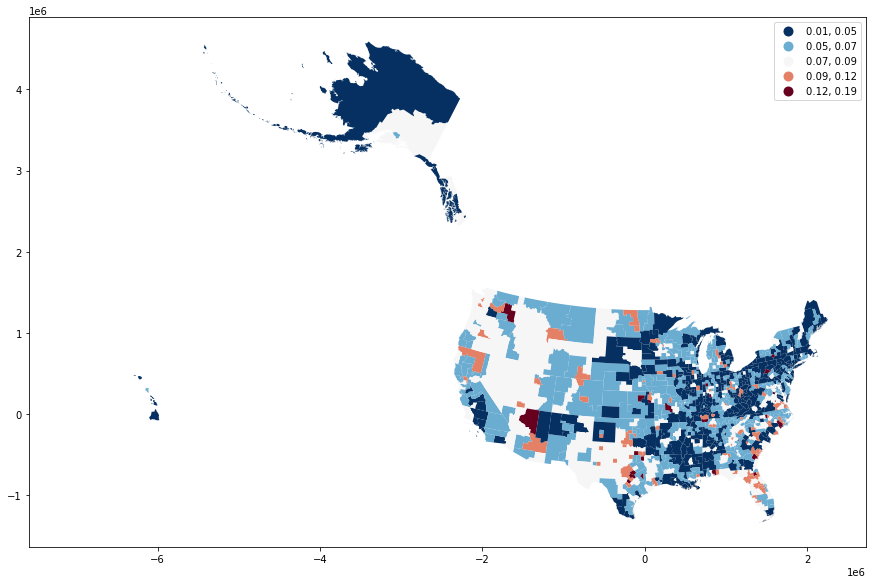

In [34]:
dest_out.plot(column='r_person',scheme='FisherJenks',
         categorical=False,
         cmap='RdBu_r',
         linewidth=5,
         legend=True)

<AxesSubplot:>

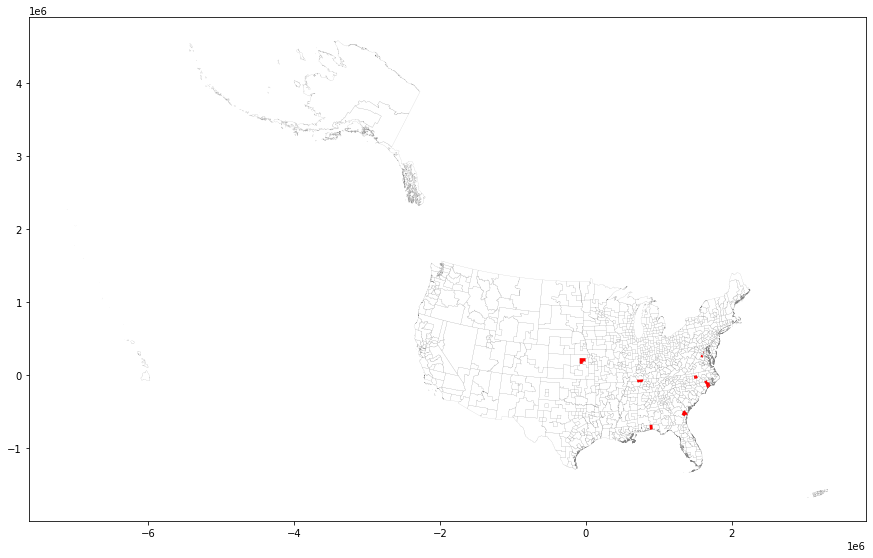

In [35]:
base = migpuma.plot(color='none',edgecolor='grey',linewidth=0.1)
orig_out.sort_values(by=['r_person'],ascending = False).head(10).plot(
        color='red',
         linewidth=1,
         ax = base,                                          
         legend=True)
#print(orig_out.sort_values(by=['r_person'],ascending = False).head(10))

     GISMATCH STATEFIP           State MIGPLAC MIGPUMA PWSTATE PWPUMA  \
276   1303600       13         Georgia     013   03600      13  03600   
714   3701400       37  North Carolina     037   01400      37  01400   
874   5151255       51        Virginia     051   51255      51  51255   
163   4803602       48           Texas     048   03602      48  03602   
243   1300200       13         Georgia     013   00200      13  00200   
522   5310600       53      Washington     053   10600      53  10600   
381   1802800       18         Indiana     018   02800      18  02800   
686   3602300       36        New York     036   02300      36  02300   
463   2901400       29        Missouri     029   01400      29  01400   
405   2000300       20          Kansas     020   00300      20  00300   

                                              geometry MIGPUMA2_x MIGPUMA_D  \
276  POLYGON ((1139970.774 -320764.357, 1140430.323...    1303600   1303600   
714  POLYGON ((1511935.874 -47907.989,

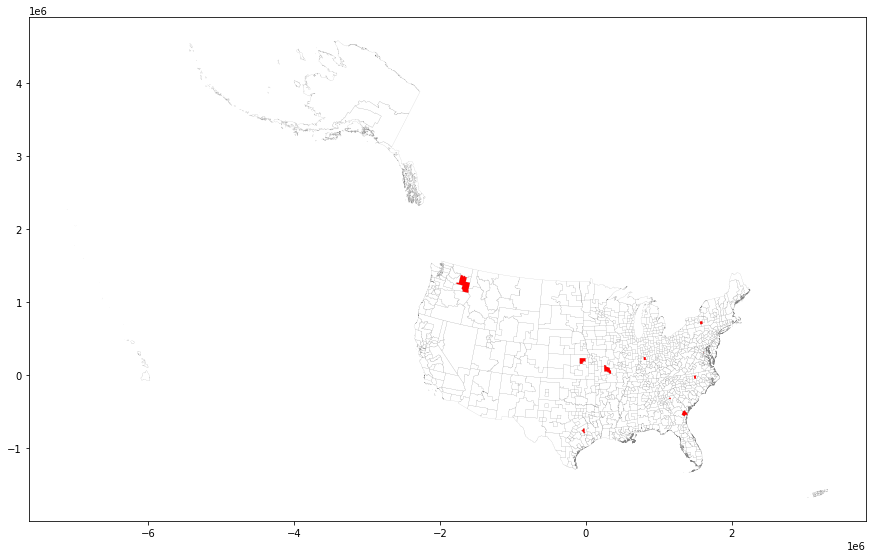

In [36]:
base = migpuma.plot(color='none',edgecolor='grey',linewidth=0.1)
dest_out.sort_values(by=['r_person'],ascending = False).head(10).plot(
        color='red',
         linewidth=1,
         ax = base,                                          
         legend=True)
print(dest_out.sort_values(by=['r_person'],ascending = False).head(10))

### Export origin, destination of population flows to shapefiles

In [37]:
orig.to_file(GIS_path+'orig.shp')
dest_mig.to_file(GIS_path+'dest_mig.shp')

dest_loc.to_file(GIS_path+'dest_loc.shp')
orig_out.to_file(GIS_path+'orig_out.shp')
dest_out.to_file(GIS_path+'dest_out.shp')

<ipython-input-37-ea645f856606>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  orig.to_file(GIS_path+'orig.shp')
<ipython-input-37-ea645f856606>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dest_mig.to_file(GIS_path+'dest_mig.shp')
<ipython-input-37-ea645f856606>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dest_loc.to_file(GIS_path+'dest_loc.shp')
<ipython-input-37-ea645f856606>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  orig_out.to_file(GIS_path+'orig_out.shp')
<ipython-input-37-ea645f856606>:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dest_out.to_file(GIS_path+'dest_out.shp')


### Join MIGPUMA areas to  OD flows

In [38]:
orig_dest1 = pd.merge(orig_dest,migpuma,how='left',left_on='MIGPUMA_O',right_on='MIGPUMA2', suffixes=('', '_y')).rename(columns={"geometry": "geometry_o"})
orig_dest1 = orig_dest1.drop(['GISMATCH','STATEFIP','State','MIGPLAC','MIGPUMA','PWSTATE','PWPUMA','MIGPUMA2'],axis=1)
orig_dest1 = pd.merge(orig_dest1,migpuma,how='left',left_on='MIGPUMA_D',right_on='MIGPUMA2', suffixes=('', '_y')).rename(columns={"geometry": "geometry_d"})
orig_dest1 = orig_dest1.drop(['GISMATCH','STATEFIP','State','MIGPLAC','MIGPUMA','PWSTATE','PWPUMA','MIGPUMA2'],axis=1)
orig_dest1 = orig_dest1.dropna(subset=['geometry_o']) # remove people migrate from oversea

In [39]:
orig_dest1['cent_o'] = gpd.GeoSeries(orig_dest1['geometry_o']).centroid
orig_dest1['cent_d'] = gpd.GeoSeries(orig_dest1['geometry_d']).centroid
orig_dest1.head()

,MIGPUMA_O,MIGPUMA_D,person,geometry_o,geometry_d,cent_o,cent_d
0,0100190,0100190,27158,"POLYGON ((792424.077 -270526.721, 792214.122 -...","POLYGON ((792424.077 -270526.721, 792214.122 -...",POINT (754135.699 -335452.431),POINT (754135.699 -335452.431)
1,0100190,0100290,1177,"POLYGON ((792424.077 -270526.721, 792214.122 -...","POLYGON ((895413.482 -285706.036, 895405.862 -...",POINT (754135.699 -335452.431),POINT (852954.954 -276214.292)
2,0100190,0100400,26,"POLYGON ((792424.077 -270526.721, 792214.122 -...","MULTIPOLYGON (((895413.482 -285706.036, 895416...",POINT (754135.699 -335452.431),POINT (914901.048 -270707.277)
3,0100190,0100600,670,"POLYGON ((792424.077 -270526.721, 792214.122 -...","POLYGON ((784484.289 -267001.821, 785040.566 -...",POINT (754135.699 -335452.431),POINT (809531.335 -299019.835)
4,0100190,0100700,316,"POLYGON ((792424.077 -270526.721, 792214.122 -...","POLYGON ((868306.699 -314428.444, 868346.868 -...",POINT (754135.699 -335452.431),POINT (813579.196 -338022.156)


## Get a list of records of local moves and export them to a csv

In [40]:
print(orig_dest1[orig_dest1['MIGPUMA_O']==orig_dest1['MIGPUMA_D']]['person'].sum())
print(orig_dest1['person'].sum())
print(df1[df1['MIGPUMA_O']==df1['MIGPUMA_D']].shape[0])
print(df1.shape[0])

26956410
43771655
1186534
2110358


In [41]:
print('Ratio of people moved locally: ' + str(orig_dest1[orig_dest1['MIGPUMA_O']==orig_dest1['MIGPUMA_D']]['person'].sum()/orig_dest1['person'].sum()))

Ratio of people moved locally: 0.6158416902445201


### Plot local move

In [42]:
local_move = orig_dest1[orig_dest1['MIGPUMA_O'] == orig_dest1['MIGPUMA_D']]
local_move['geometry'] = local_move['geometry_o']
local_move = gpd.GeoDataFrame(local_move)

<ipython-input-42-a6adcd78d8ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_move['geometry'] = local_move['geometry_o']


<AxesSubplot:>

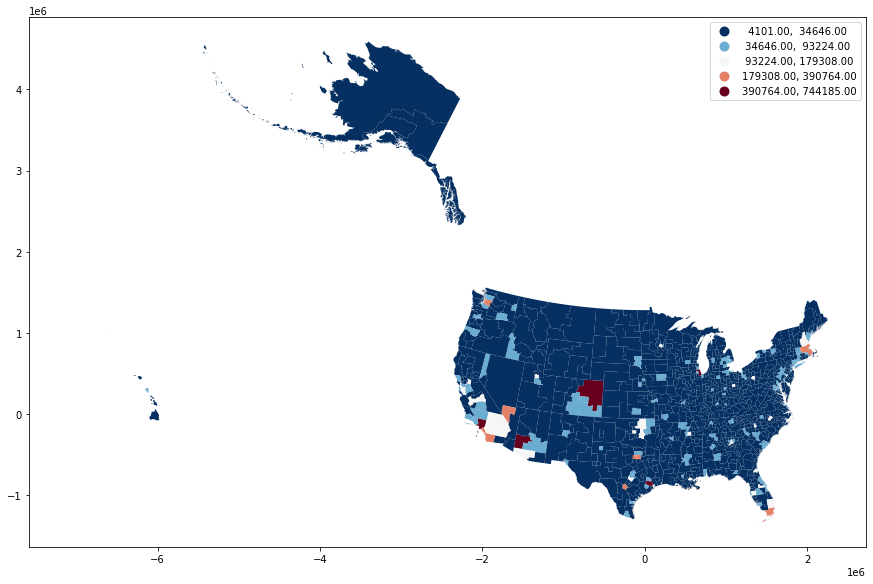

In [43]:
local_move.plot(column='person',scheme='FisherJenks',
         categorical=False,
         cmap='RdBu_r',
         linewidth=5,
         legend=True)

### Find State of MIGPUMA

In [44]:
orig_dest1['STFIPS_O'] = orig_dest1['MIGPUMA_O'].astype(str).str[0:2]
orig_dest1['STFIPS_D'] = orig_dest1['MIGPUMA_D'].astype(str).str[0:2]

In [45]:
x_o = orig_dest1['cent_o'].apply(lambda p: p.x)
x_d = orig_dest1['cent_d'].apply(lambda p: p.x)
y_o = orig_dest1['cent_o'].apply(lambda p: p.y)
y_d = orig_dest1['cent_d'].apply(lambda p: p.y)
orig_dest1['Dist'] = ((x_o - x_d)**2+(y_o-y_d)**2)**0.5

In [46]:
orig_dest1['STATE_O'] = orig_dest1['STFIPS_O'].apply(lambda p:us.states.lookup(p).abbr)
orig_dest1['STATE_D'] = orig_dest1['STFIPS_D'].apply(lambda p:us.states.lookup(p).abbr)

### Plot flow trajectories

In [47]:
out_move = orig_dest1[orig_dest1['STATE_O'] != orig_dest1['STATE_D']]
out_move['geometry'] = out_move.apply(lambda x: LineString([x['cent_o'], x['cent_d']]),axis=1)
out_move = gpd.GeoDataFrame(out_move)

<ipython-input-47-504293ebd976>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_move['geometry'] = out_move.apply(lambda x: LineString([x['cent_o'], x['cent_d']]),axis=1)


In [48]:
out_move.drop(columns=['geometry','geometry_o','geometry_d']).to_csv(intermediate_path+"out_move.csv")

In [49]:
top_out_move = out_move.sort_values(by='person', ascending=False)

In [50]:
top_out_move = top_out_move.iloc[0:1000]

In [51]:
top_out_move = top_out_move.sort_values(by='person', ascending=True)

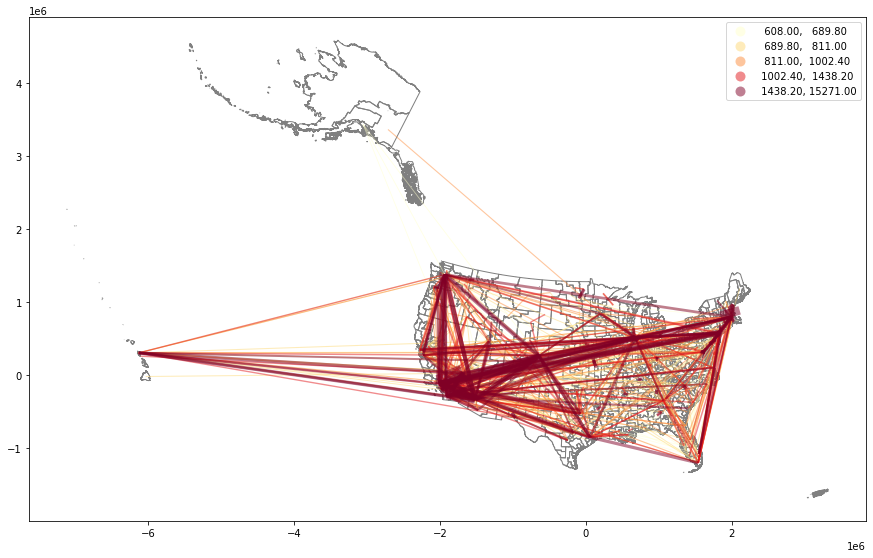

In [52]:
base = migpuma.plot(facecolor = 'none',edgecolor='grey')
ax = top_out_move.plot(column='person',scheme='quantiles',
         categorical=False,
         cmap='YlOrRd',
         linewidth=top_out_move['person']/top_out_move['person'].max()*20,
         alpha = 0.5,
         legend=True,
        ax=base)

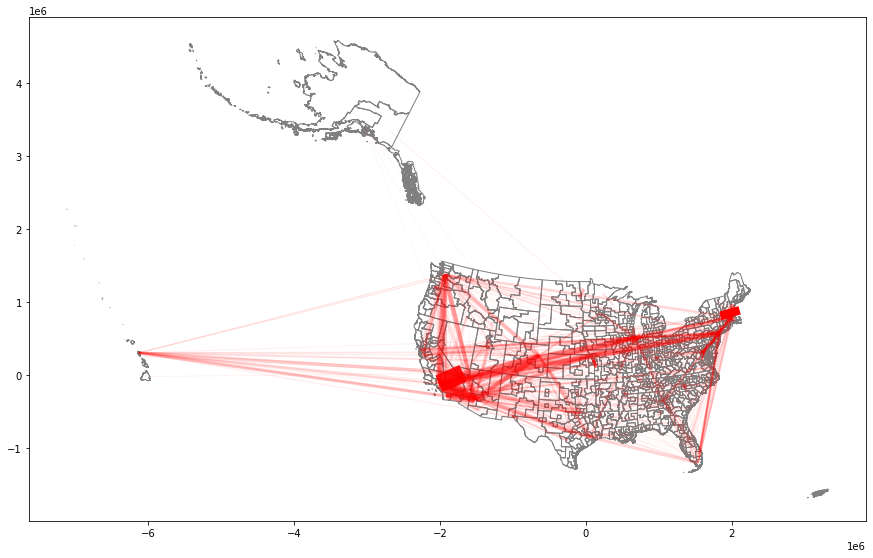

In [53]:
base = migpuma.plot(facecolor = 'none',edgecolor='grey')
max_move = top_out_move['person'].max()
for index, row in top_out_move.iterrows():
    Geoseries = gpd.GeoSeries(row['geometry'])

    ax = Geoseries.plot(color='red',
             linewidth = row['person']/max_move*20,
             alpha = row['person']/max_move,
             ax=base)

In [54]:
top_out_move.sort_values(by='person', ascending=False).head(10)

,MIGPUMA_O,MIGPUMA_D,person,geometry_o,geometry_d,cent_o,cent_d,STFIPS_O,STFIPS_D,Dist,STATE_O,STATE_D,geometry
62777,2500390,3300290,15271,"MULTIPOLYGON (((2039681.796 718711.231, 203968...","MULTIPOLYGON (((2020196.596 873122.836, 202021...",POINT (1995010.017 793862.726),POINT (1962762.050 907395.106),25,33,118023.441771,MA,NH,"LINESTRING (1995010.017 793862.726, 1962762.05..."
8821,0603700,3200400,13910,"MULTIPOLYGON (((-2068638.892 -280608.510, -206...","POLYGON ((-1585096.670 77383.374, -1585158.643...",POINT (-2010993.187 -119561.572),POINT (-1682597.013 24789.230),06,32,358721.621197,CA,NV,"LINESTRING (-2010993.187 -119561.572, -1682597..."
19450,1100100,2401100,12541,"MULTIPOLYGON (((1621874.788 308852.744, 162187...","MULTIPOLYGON (((1623559.188 296503.355, 162357...",POINT (1620150.769 320414.912),POINT (1636255.529 314776.690),11,24,17063.201260,DC,MD,"LINESTRING (1620150.769 320414.912, 1636255.52..."
41949,1703400,1800100,8380,"POLYGON ((699257.800 502695.428, 699259.630 50...","POLYGON ((724932.385 495571.186, 724935.603 49...",POINT (673963.032 515214.575),POINT (713904.366 471206.148),17,18,59431.067696,IL,IN,"LINESTRING (673963.032 515214.575, 713904.366 ..."
73450,2901000,2000600,7604,"POLYGON ((152923.987 192772.316, 153014.181 19...","POLYGON ((119412.555 173940.048, 119413.149 17...",POINT (141880.660 170304.412),POINT (101208.533 155718.648),29,20,43208.406191,MO,KS,"LINESTRING (141880.660 170304.412, 101208.533 ..."
81031,3300290,2500390,7379,"MULTIPOLYGON (((2020196.596 873122.836, 202021...","MULTIPOLYGON (((2039681.796 718711.231, 203968...",POINT (1962762.050 907395.106),POINT (1995010.017 793862.726),33,25,118023.441771,NH,MA,"LINESTRING (1962762.050 907395.106, 1995010.01..."
8505,0603700,0400100,7266,"MULTIPOLYGON (((-2068638.892 -280608.510, -206...","POLYGON ((-1414492.638 -276260.452, -1414216.2...",POINT (-2010993.187 -119561.572),POINT (-1517301.083 -332612.724),06,04,537701.298767,CA,AZ,"LINESTRING (-2010993.187 -119561.572, -1517301..."
62928,2500390,4400100,6673,"MULTIPOLYGON (((2039681.796 718711.231, 203968...","MULTIPOLYGON (((2009457.306 738828.040, 200943...",POINT (1995010.017 793862.726),POINT (1990436.098 746990.586),25,44,47094.779032,MA,RI,"LINESTRING (1995010.017 793862.726, 1990436.09..."
19449,1100100,2401000,5720,"MULTIPOLYGON (((1621874.788 308852.744, 162187...","POLYGON ((1625839.373 346836.846, 1625837.217 ...",POINT (1620150.769 320414.912),POINT (1599222.204 342073.145),11,24,30117.833889,DC,MD,"LINESTRING (1620150.769 320414.912, 1599222.20..."
48973,2000600,2901000,5545,"POLYGON ((119412.555 173940.048, 119413.149 17...","POLYGON ((152923.987 192772.316, 153014.181 19...",POINT (101208.533 155718.648),POINT (141880.660 170304.412),20,29,43208.406191,KS,MO,"LINESTRING (101208.533 155718.648, 141880.660 ..."


### Plot the top 10 migration flows

In [55]:
top_out_move_rproj = top_out_move.drop(columns=['geometry_o','geometry_d','geometry'])
(top_out_move_rproj['cent_d_x'], top_out_move_rproj['cent_d_y']) = (top_out_move_rproj['cent_d'].to_crs(4326).x, top_out_move_rproj['cent_d'].to_crs(4326).y)
(top_out_move_rproj['cent_o_x'], top_out_move_rproj['cent_o_y']) = (top_out_move_rproj['cent_o'].to_crs(4326).x, top_out_move_rproj['cent_o'].to_crs(4326).y)

In [56]:
top_out_move_rproj.drop(columns=['cent_o','cent_d']).sort_values(by='person', ascending=False).head(100).to_csv(table_path+'top_out_move.csv')
top_out_move.sort_values(by='person', ascending=False).head(100).to_csv(GIS_path+'top_out_move.shp')

## Join out_move to MSA

In [ ]:
# Read census tract PUMA relationship file
ct_puma_rel = pd.read_csv(table_path+'census_tract_PUMA_relationship.csv',dtype={'STATEFP': 'string', 'COUNTYFP': 'string','TRACTCE': 'string','PUMA5CE': 'string'})

ct_puma_rel['PUMA2'] = ct_puma_rel['STATEFP'] + ct_puma_rel['PUMA5CE'] 
ct_puma_rel['COUNTY_FIPS'] = ct_puma_rel['STATEFP'] + ct_puma_rel['COUNTYFP'] 
ct_puma_rel['TRACT_FIPS'] = ct_puma_rel['STATEFP'] + ct_puma_rel['COUNTYFP'] + ct_puma_rel['TRACTCE']

In [ ]:
# Read MSA county relationship file
MSA_2018 = pd.read_excel(table_path+'MSA_delineation_2018.xls')

MSA_2018['FIPS State Code']  = MSA_2018['FIPS State Code'].astype('int64').astype('str').str.rjust(2, "0")
MSA_2018['FIPS County Code']  = MSA_2018['FIPS County Code'].astype('int64').astype('str').str.rjust(3, "0")
MSA_2018['COUNTY_FIPS'] = MSA_2018['FIPS State Code'] + MSA_2018['FIPS County Code']
MSA_2018 = MSA_2018.rename(columns={'CBSA Code':'CBSA_Code'})
MSA_2018 = MSA_2018.drop(columns=['Metropolitan Division Code','CSA Code','Metropolitan Division Title','CSA Title'])

#### Join census tract to MSA through county fips

In [ ]:
ct_msa = pd.merge(ct_puma_rel, MSA_2018, how = 'inner', on = 'COUNTY_FIPS')

#### Join MIGPUMA to MSA

In [ ]:
ct_msa = pd.merge(trans,ct_msa,how = 'inner',on = 'PUMA2')[['MIGPUMA','CBSA_Code']].drop_duplicates(subset=['MIGPUMA','CBSA_Code'])

In [ ]:
ct_msa.head()

In [ ]:
ct_msa.shape

In [ ]:
ct_msa['MIGPUMA'].unique().shape

In [ ]:
ct_msa['CBSA_Code'].unique().shape